# Load Constrained Layout Optimization

[Try this yourself](https://colab.research.google.com/github/DTUWindEnergy/TopFarm2/blob/master/docs/notebooks/layout_and_loads.ipynb) (requires google account)


## Install TopFarm and PyWake

In [1]:
# Install TopFarm if needed
import importlib
if not importlib.util.find_spec("topfarm"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/TopFarm2.git

## Import section

In [16]:
import numpy as np
from numpy import newaxis as na
import time

from topfarm.cost_models.cost_model_wrappers import AEPMaxLoadCostModelComponent
from topfarm.easy_drivers import EasyScipyOptimizeDriver
from topfarm import TopFarmProblem
from topfarm.plotting import NoPlot
from topfarm.constraint_components.boundary import XYBoundaryConstraint
from topfarm.constraint_components.spacing import SpacingConstraint

from py_wake.examples.data.lillgrund import LillgrundSite
from py_wake.deficit_models.gaussian import IEA37SimpleBastankhahGaussian, NiayifarGaussian
from py_wake.turbulence_models.stf import STF2017TurbulenceModel
from py_wake.examples.data.iea34_130rwt import IEA34_130_1WT_Surrogate 
from py_wake.superposition_models import MaxSum
from py_wake.wind_turbines.power_ct_functions import SimpleYawModel

## Select site, turbines, wake model and additional models and set up PyWake objects

In [4]:
site = LillgrundSite()
windTurbines = IEA34_130_1WT_Surrogate()
wfm = IEA37SimpleBastankhahGaussian(site, windTurbines, turbulenceModel=STF2017TurbulenceModel(addedTurbulenceSuperpositionModel=MaxSum()))

## Choose flow cases 
 (this will determine the speed and accuracy of the simulation). In this example we will focus on only a few flow cases.

In [5]:
wsp = np.asarray([10, 15])
wdir = np.arange(0,360,45)

## Constrain loads
 In this example we will calculate nominal loads and use this as a basis for the load constraint.

In [37]:
x, y = site.initial_position.T
#keeping only every second turbine as lillegrund turbines are approx. half the size of the iea 3.4MW
x = x[::2]
y = y[::2]
x_init = x
y_init = y
n_wt = x.size
i = n_wt
k = wsp.size
l = wdir.size
load_fact = 1.002
simulationResult = wfm(x,y,wd=wdir, ws=wsp)
nom_loads = simulationResult.loads('OneWT')['LDEL'].values
max_loads = nom_loads * load_fact
s = nom_loads.shape[0]
load_signals = ['del_blade_flap', 'del_blade_edge', 'del_tower_bottom_fa',
                'del_tower_bottom_ss', 'del_tower_top_torsion']

## Configure the optimization
 this includes e.g. selection of maximum number of iterations, convergence tolerance, optimizer algorithm and design variable boundaries

In [38]:
maxiter = 5
tol = 1e-8
driver = EasyScipyOptimizeDriver(optimizer='SLSQP', maxiter=maxiter, tol=tol)
ec = 1e-2
step = 1e-4
min_spacing = 260
xi, xa = x_init.min()-min_spacing, x_init.max()+min_spacing
yi, ya = y_init.min()-min_spacing, y_init.max()+min_spacing
boundary = np.asarray([[xi, ya], [xa, ya], [xa, yi], [xi, yi]])

## Setup cost function

In [39]:
def aep_load_func(x, y):
    simres = wfm(x, y, wd=wdir, ws=wsp)
    aep = simres.aep().sum()
    loads = simres.loads('OneWT')['LDEL'].values
    return aep, loads

## Setup gradient function
 In this example we will rely on the automatic finite difference, so no need to specify gradients

## Wrap your pure python cost and gradient functions in a topfarm component

In [40]:
cost_comp = AEPMaxLoadCostModelComponent(input_keys=[('x', x_init),('y', y_init)],
                                          n_wt = n_wt,
                                          aep_load_function = aep_load_func,
                                          max_loads = max_loads, 
                                          objective=True,
                                          step={'x': step, 'y': step},
                                          output_keys=[('AEP', 0), ('loads', np.zeros((s, i)))]
                                          )

## Set up the TopFarm problem

In [41]:
problem = TopFarmProblem(design_vars={'x': x_init, 'y': y_init},
                        constraints=[XYBoundaryConstraint(boundary),
                                     SpacingConstraint(min_spacing)],
                          cost_comp=cost_comp,
                          driver=driver,
                          plot_comp=NoPlot(),
                          expected_cost=ec)

## Optimize

In [42]:
cost, state, recorder = problem.optimize()

Iteration limit exceeded    (Exit mode 9)
            Current function value: -36978.307022695444
            Iterations: 6
            Function evaluations: 6
            Gradient evaluations: 6
Optimization FAILED.
Iteration limit exceeded
-----------------------------------


## Plot results
 Try to run the commands below to watch the resulting wake map for different flow cases

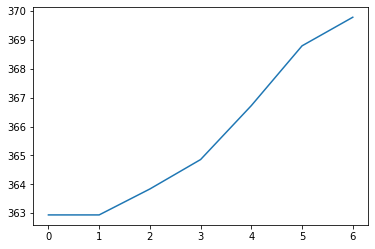

In [45]:
# import matplotlib.pyplot as plt
# plt.plot(recorder['AEP'])

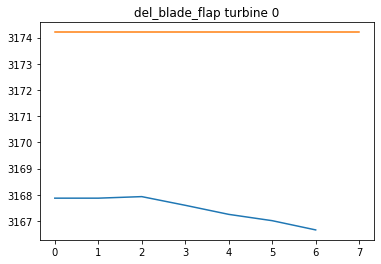

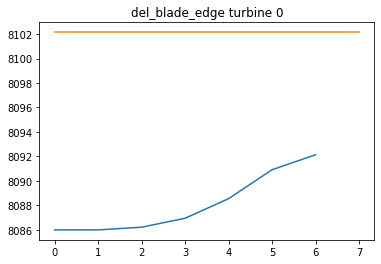

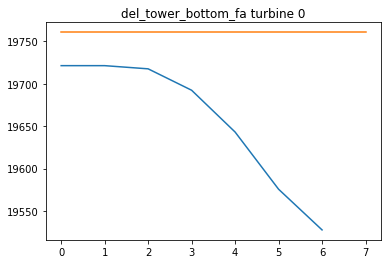

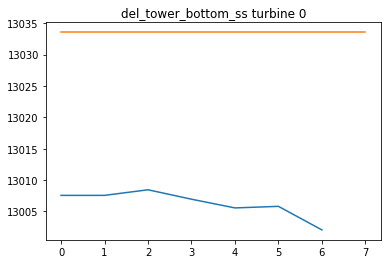

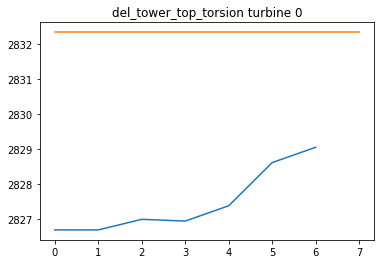

In [46]:
# n_i = recorder['counter'].size
# loads = recorder['loads'].reshape((n_i,s,n_wt))
# wt = 0
# for n, ls in enumerate(load_signals):
#   plt.plot(loads[:,n,wt])
#   plt.title(ls+f' turbine {wt}')
#   plt.plot([0, n_i], [max_loads[n, wt], max_loads[n, wt]])
#   plt.show()